# 군집 - DBSCAN(4) - 교통사고 밀집지역

## #01. 패키지

In [1]:
import sys
import numpy as np
import seaborn as sb
from pandas import read_excel
from matplotlib import pyplot as plt

# 2개의 list를 사용해 조합을 만들어주는 패키지
from itertools import combinations 
from itertools import product

# 클러스터 알고리즘 참조
from sklearn.cluster import DBSCAN

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
# 평가
from sklearn.metrics import silhouette_score

## #02. 데이터

In [2]:
origin = read_excel("https://data.hossam.kr/G02/traffic.xlsx")
print(origin.info())
origin.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2658 entries, 0 to 2657
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   발생년         2658 non-null   int64         
 1   발생년월일시      2658 non-null   datetime64[ns]
 2   주야          2658 non-null   object        
 3   요일          2658 non-null   object        
 4   사망자수        2658 non-null   int64         
 5   부상자수        2658 non-null   int64         
 6   중상자수        2658 non-null   int64         
 7   경상자수        2658 non-null   int64         
 8   부상신고자수      2658 non-null   int64         
 9   발생지시도       2658 non-null   object        
 10  발생지시군구      2658 non-null   object        
 11  사고유형_대분류    2658 non-null   object        
 12  사고유형_중분류    2658 non-null   object        
 13  사고유형        2658 non-null   object        
 14  가해자법규위반     2658 non-null   object        
 15  도로형태_대분류    2658 non-null   object        
 16  도로형태        2658 non-nul

,발생년,발생년월일시,주야,요일,사망자수,부상자수,중상자수,경상자수,부상신고자수,발생지시도,...,사고유형,가해자법규위반,도로형태_대분류,도로형태,가해자_당사자종별,피해자_당사자종별,발생위치X_UTMK,발생위치Y_UTMK,경도,위도
0,2022,2022-01-01 10:00:00,주,토,1,0,0,0,0,전남,...,공작물충돌,안전운전 의무 불이행,단일로,교량위,승용차,없음,1000059,1660526,127.500646,34.939564
1,2022,2022-01-01 14:00:00,주,토,1,0,0,0,0,전북,...,추돌,안전운전 의무 불이행,단일로,기타단일로,원동기장치자전거,승용차,965929,1760951,127.122710,35.844490
2,2022,2022-01-01 17:00:00,주,토,1,0,0,0,0,경기,...,도로이탈 추락,안전운전 의무 불이행,단일로,기타단일로,이륜차,없음,966667,2021002,127.119365,38.188669
3,2022,2022-01-01 20:00:00,야,토,1,0,0,0,0,부산,...,기타,안전운전 의무 불이행,단일로,고가도로위,승용차,승용차,1156990,1697307,129.225773,35.258920
4,2022,2022-01-02 06:00:00,주,일,1,0,0,0,0,서울,...,횡단중,안전운전 의무 불이행,단일로,기타단일로,승합차,보행자,950217,1953529,126.936182,37.579800


## #03. 데이터 전처리

### 필요한 데이터만 추출

In [4]:
df = origin.query("발생지시도 == '서울' and 사망자수 > 0")
print(df.shape)
df.head()

(215, 23)


,발생년,발생년월일시,주야,요일,사망자수,부상자수,중상자수,경상자수,부상신고자수,발생지시도,...,사고유형,가해자법규위반,도로형태_대분류,도로형태,가해자_당사자종별,피해자_당사자종별,발생위치X_UTMK,발생위치Y_UTMK,경도,위도
4,2022,2022-01-02 06:00:00,주,일,1,0,0,0,0,서울,...,횡단중,안전운전 의무 불이행,단일로,기타단일로,승합차,보행자,950217,1953529,126.936182,37.579800
11,2022,2022-01-03 18:00:00,야,월,1,0,0,0,0,서울,...,횡단중,안전운전 의무 불이행,단일로,기타단일로,승용차,보행자,947053,1945537,126.900927,37.507591
20,2022,2022-01-05 04:00:00,야,수,1,0,0,0,0,서울,...,차도통행중,안전운전 의무 불이행,교차로,교차로내,승용차,보행자,953351,1942887,126.972351,37.484045
22,2022,2022-01-05 06:00:00,주,수,1,0,0,0,0,서울,...,횡단중,보행자 보호의무 위반,단일로,기타단일로,건설기계,보행자,954021,1942097,126.979979,37.476959
31,2022,2022-01-06 21:00:00,야,목,1,0,0,0,0,서울,...,횡단중,신호위반,단일로,기타단일로,이륜차,보행자,957084,1949762,127.014172,37.546193


### 군집에 사용할 데이터를 표준화

In [5]:
x = df[['경도', '위도']]
scaler = StandardScaler()
'''
fit_transform은 fit, transform을 결합한 형태
학습과 예측치 산정을 동시에 수행해 학습 데이터를 받을 수 없음
학습 결과를 재사용할 경우 transform() 함수를 사용'''
# DF의 데이터 학습 후 DF의 각 열의 값을 해당 열의 최소값과 최대값 사이의 범위로 변환한 새로운 데이터 배열
n_data = scaler.fit_transform(x)
n_data[:5]

array([[-0.49295687,  0.81624643],
       [-0.88651335, -0.68436506],
       [-0.0892039 , -1.17366995],
       [-0.00405861, -1.32094612],
       [ 0.37764499,  0.11784443]])

## #04. sorted-k-dist 그래프

-`NearestNeighbors`의 n_neighbors 파라미터 : 가까운 이웃의 수 설정(기본 값 = 5)

- `DBSCAN`의 MinPts : 핵심 포인트가 되기 위한 이웃의 수(주로 4 아니면 5)

n_neighbors = MinPts

In [12]:
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(n_data)
dist, indi = neighbors_fit.kneighbors(n_data)
# 정렬
s_dist = np.sort(dist,axis=0)
# print(dist[:5])
# print(indi[:5])
# print(s_dist[:5])

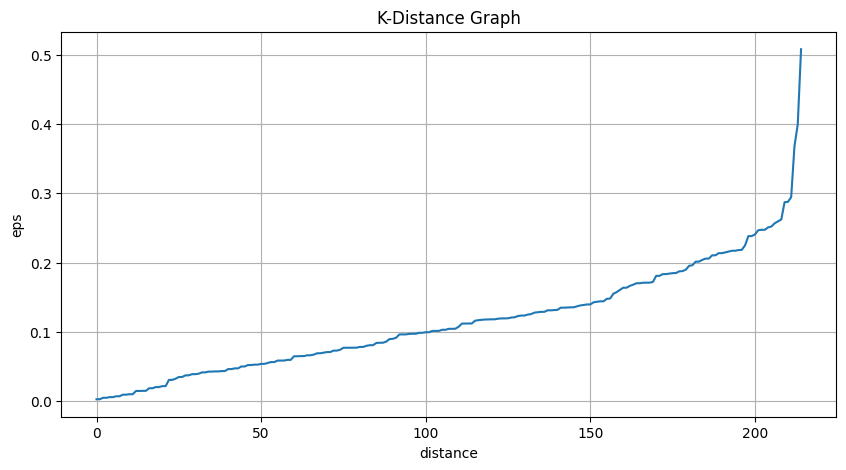

In [13]:
plt.figure(figsize=(10,5))
# [:,1] 2차 배열에서 열단위로 끊는다
plt.plot(s_dist[:,1])
plt.title("K-Distance Graph")
plt.ylabel("eps")
plt.xlabel("distance")
plt.grid()
plt.show()
plt.close()

> 경사가 급격히 변하는 지점을 확인, 그 부분이 eps.

> eps 값을 0.2, 0.3으로 설정해 군집 결과를 비교.

## #05. DBSCAN 모델 구축

### 1. 조건값 설정 

In [14]:
eps = [0.2, 0.3]
minPts = [4,5]

### 2. 군집화 및 결과 평가

eps = 0.2, min_samples = 4
clster label : [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
silhouette_score : 0.0745649278380414

clusters : [-1  0 15 -1 11  1  7  2  0  2  0  2 -1  3  4  0  5  2 -1 -1  6  9  0 -1
  7  8 -1  3  1  0  0 -1  1 -1  9  3 -1  0  9  0  1 -1  9  9 -1 -1  6  5
 -1  9 -1 -1  2 -1  0 10  9  7  7 -1 -1  2 13  0 -1  0 10  2  0 -1 -1  1
  8  9  2  0 -1  7  0  5  0  2 -1 -1  2 -1 -1 -1 -1 -1 -1 15 -1 -1  4 -1
  0  1  8 11  5  0 -1  7  7  9  7 -1  0 10 15 -1 12  5 -1  0  2  1 -1 -1
  0  5  9  8 -1  5  0 -1 -1 -1 -1 -1  0  0 10 -1 -1  5  0 -1 13  5 -1 10
 -1  4  1  0 13 12  5 13  2  2 10 -1 14  6 12 12  9 11  0 14 -1  1  0  1
 -1  5 -1  0  3  2 14 13 -1 12  5 12  3  5 -1  5 14 11  5  0  9 -1 -1  0
 -1  4 14  5  0  5 13 11 -1  5  0 -1 -1  7 15 -1  0 -1 -1  6 -1  0 -1]


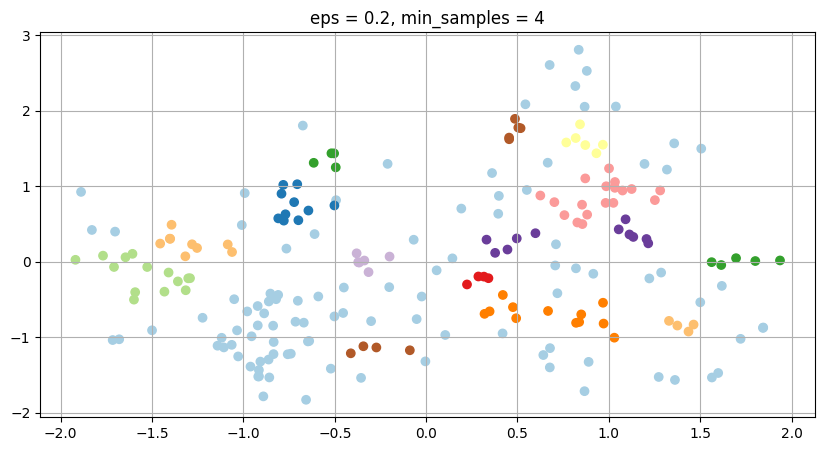


eps = 0.2, min_samples = 5
clster label : [-1  0  1  2  3  4  5  6  7  8  9 10]
silhouette_score : -0.030130955148575292

clusters : [-1  0 -1 -1 -1  1  3  2  0  2  0  2 -1 -1 -1  0  6  2 -1 -1 -1  5  0 -1
  3 -1 -1 -1  1  0 -1 -1 -1 -1  4 -1 -1  0  5  0 -1 -1  5  4 -1 -1 -1  6
 -1  4 -1 -1  2 -1  0  7  4  3  3 -1 -1  2  9  0 -1  0  7  2  0 -1 -1  1
 -1  5  2  0 -1  3  0  6  0  2 -1 -1  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  0 -1 -1 -1  6  0 -1  3  3  4  3 -1  0  7 -1 -1  8  6 -1  0  2  1 -1 -1
  0 -1  4 -1 -1  6  0 -1 -1 -1 -1 -1  0  0  7 -1 -1  6  0 -1  9  6 -1  7
 -1 -1  1  0  9  8  6  9  2  2  7 -1 10 -1  8  8  5 -1  0 10 -1  1  0  1
 -1  6 -1  0 -1  2 10  9 -1  8  6  8 -1  6 -1  6 10 -1  6  0  5 -1 -1  0
 -1 -1 10  6  0  6  9 -1 -1  6  0 -1 -1  3 -1 -1  0 -1 -1 -1 -1  0 -1]


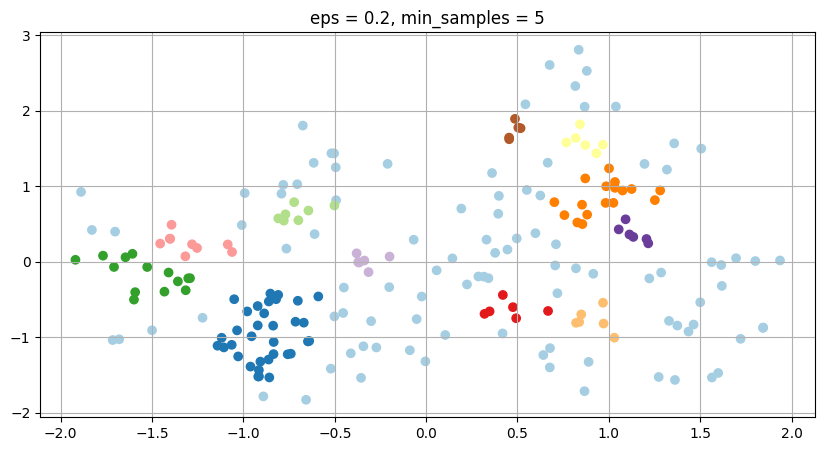


eps = 0.3, min_samples = 4
clster label : [-1  0  1  2  3  4  5  6  7]
silhouette_score : 0.13047665687331503

clusters : [ 0  0  0  0  1  0  0  0  0  0  0  0 -1  2  0  0  1  0  0  0  1  1  0  5
  0  3 -1  2  0  0  0  0  0  1  1  2  1  0  1  0  0  1  1  1  1  1  1  1
  6  1 -1 -1  0  1  0  0  1  0  0  7  1  0  1  0  1  0  0  0  0  0  4  0
  3  1  0  0  0  0  0  1  0  0 -1  5  0  7 -1  1  1  0  1  0  0  1  0  0
  0  0  3  1  1  0 -1  0  0  1  0  1  0  0  0  0  1  1  4  0  0  0  1  4
  0  1  1  3  0  1  0 -1 -1  0  1  0  0  0  0  0  1  1  0  2  1  1  1  0
 -1  0  0  0  1  1  1  1  0  0  0  0  6  1  1  1  1  1  0  6  0  0  0  0
  0  1  3  0  2  0  6  1 -1  1  1  1  2  1 -1  1  6  1  1  0  1  7  5  0
  1  0  6  1  0  1  1  1  0  1  0  5  0  0  0 -1  0 -1  1  1  4  0  0]


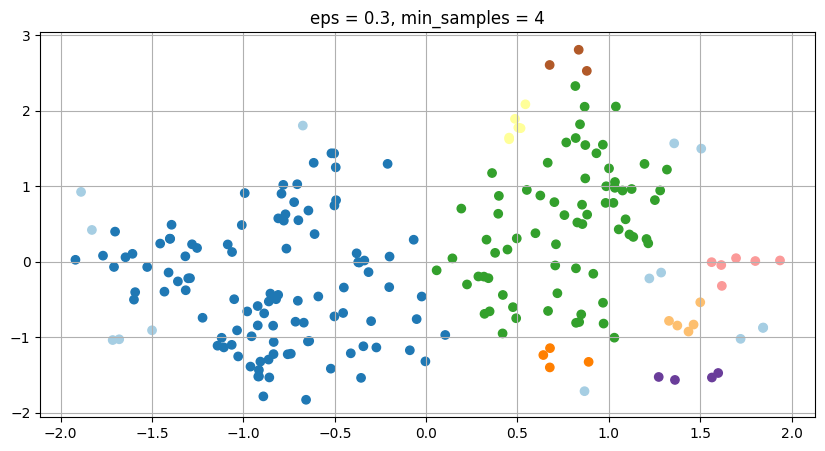


eps = 0.3, min_samples = 5
clster label : [-1  0  1  2  3  4  5  6]
silhouette_score : -0.11868242696621044

clusters : [ 0  0  1  1  2  0  0  0  0  0  0  0 -1  3  0  0  2  0  0  0  2  2  0 -1
  0  5 -1  3  0  0  0  4  0  2  2  3  2  0  2  0  0 -1  2  2  2 -1  2  2
  6  2 -1 -1  0  2  0  4  2  0  0 -1  2  0  2  0 -1  0  4  0  0  0 -1  0
  5  2  0  0  0  0  0  2  0  0 -1 -1  0 -1 -1 -1  2  0  2  0  0  2  0  2
  0  0  5  2  2  0 -1  0  0  2  0  2  0  4  0  0  2  2 -1  0  0  0  2 -1
  0  2  2  5  4  2  0 -1 -1  0  2  0  0  0  4 -1  2  2  0  3  2  2  2  4
 -1  0  0  0  2  2  2  2  0  0  4  0  6  2  2  2  2  2  0  6  1  0  0  0
  0  2  5  0  3  0  6  2 -1  2  2  2  3  2 -1  2  6  2  2  0  2 -1 -1  0
  2  0  6  2  0  2  2  2  0  2  0 -1  0  0  0 -1  0 -1  2  2 -1  0 -1]


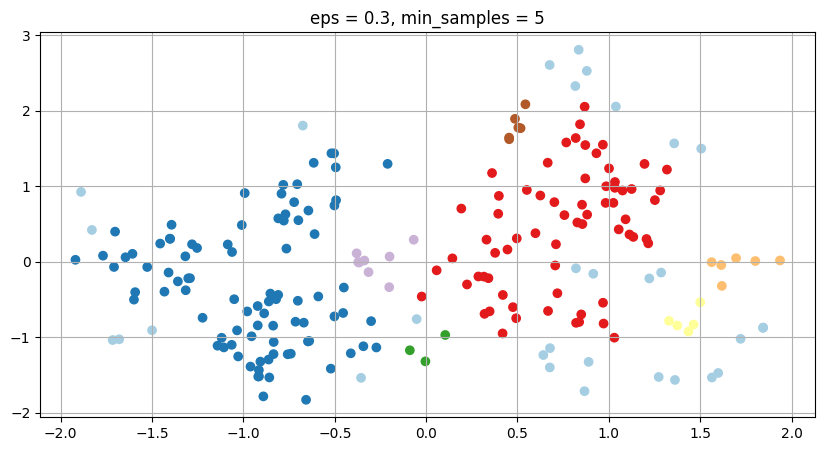

In [32]:
# 두 리스트의 원소를 조합해 경우의 수 생성
# 파라미터를 무제한으로 전달될 경우 *를 사용
# *는 파라미터가 가변적으로 전달될 수 있음을 나타냄.
prod = list(product(*[eps, minPts]))
for e,m in prod:
    # print(e,m)
    # dbscan = DBSCAN(eps=e, min_samples=m)
    dbscan = DBSCAN(eps=e, min_samples=m, n_jobs=-1)
    clusters = dbscan.fit_predict(n_data)

    print(f"eps = {e}, min_samples = {m}")
    print("clster label :", np.unique(clusters))
    print("silhouette_score :", silhouette_score(n_data, clusters))

    plt.figure(figsize=(10,5))
    plt.scatter(n_data[:,0], n_data[:,1], c=clusters, cmap="Paired")
    plt.title("eps = %s, min_samples = %s"%(str(e), str(m)))
    print()
    print("clusters :",clusters)
    plt.grid()
    plt.show()
    plt.close()
    print()

## #06. 최종 모델 선정

> eps = 0.2, min_samples = 4

### 군집모델 정의

In [18]:
dbscan = DBSCAN(eps = 0.2, min_samples = 4, n_jobs=-1)
# # 1번
# dbscan.fit(n_data)
# 2번
clusters = dbscan.fit_predict(n_data)
clusters[:5]

array([-1,  0, 15, -1, 11], dtype=int64)

### 핵심 포인트 얻기

clusters에서 특정 조건을 갖는 항목의 index 정보

In [20]:
core_sample_indis = dbscan.core_sample_indices_
# clusters에서 특정 조건을 갖는 항목의 index 정보
core_sample_indis[:5]

array([ 1,  5,  8,  9, 10], dtype=int64)

### 학습 데이터 중에서 핵심 포인트의 인덱스와 일치하는 데이터 찾기

In [21]:
is_core_samples = []

for i in range(0, n_data.shape[0]):
    if i in core_sample_indis:
        is_core_samples.append(1)
    else:
        is_core_samples.append(0)
print(is_core_samples)
# 1은 교통사고 자주, 0은 교통사고 비교적 적게 발생 지역

[0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0]


### 결과 시각화

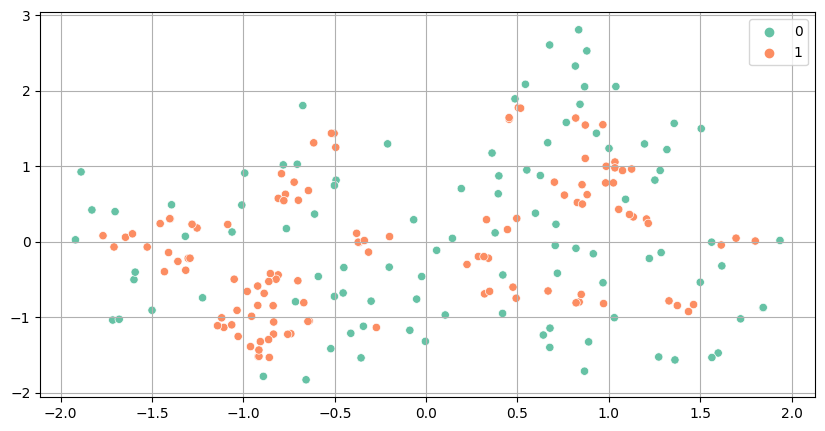

In [22]:
plt.figure(figsize=(10,5))
# [:,0], [:,1] 2차 배열에서 열단위로 끊는다
sb.scatterplot(x=n_data[:,0], y=n_data[:,1], hue=is_core_samples, palette="Set2")
plt.grid()
plt.show()
plt.close()

## #07. 분석 결과

In [25]:
df.columns

Index(['발생년', '발생년월일시', '주야', '요일', '사망자수', '부상자수', '중상자수', '경상자수', '부상신고자수',
       '발생지시도', '발생지시군구', '사고유형_대분류', '사고유형_중분류', '사고유형', '가해자법규위반',
       '도로형태_대분류', '도로형태', '가해자_당사자종별', '피해자_당사자종별', '발생위치X_UTMK',
       '발생위치Y_UTMK', '경도', '위도'],
      dtype='object')

In [26]:
result_df = df.filter(['발생지시도', '발생지시군구', '사고유형', '가해자법규위반',
                           '도로형태_대분류', '가해자_당사자종별', '피해자_당사자종별',
                           '경도', '위도'])
result_df.head()

,발생지시도,발생지시군구,사고유형,가해자법규위반,도로형태_대분류,가해자_당사자종별,피해자_당사자종별,경도,위도
4,서울,서대문구,횡단중,안전운전 의무 불이행,단일로,승합차,보행자,126.936182,37.579800
11,서울,영등포구,횡단중,안전운전 의무 불이행,단일로,승용차,보행자,126.900927,37.507591
20,서울,동작구,차도통행중,안전운전 의무 불이행,교차로,승용차,보행자,126.972351,37.484045
22,서울,동작구,횡단중,보행자 보호의무 위반,단일로,건설기계,보행자,126.979979,37.476959
31,서울,성동구,횡단중,신호위반,단일로,이륜차,보행자,127.014172,37.546193


In [27]:
# 필드 추가
result_df['cluster'] = clusters
result_df['core'] = is_core_samples
result_df.head()

,발생지시도,발생지시군구,사고유형,가해자법규위반,도로형태_대분류,가해자_당사자종별,피해자_당사자종별,경도,위도,cluster,core
4,서울,서대문구,횡단중,안전운전 의무 불이행,단일로,승합차,보행자,126.936182,37.579800,-1,0
11,서울,영등포구,횡단중,안전운전 의무 불이행,단일로,승용차,보행자,126.900927,37.507591,0,1
20,서울,동작구,차도통행중,안전운전 의무 불이행,교차로,승용차,보행자,126.972351,37.484045,15,0
22,서울,동작구,횡단중,보행자 보호의무 위반,단일로,건설기계,보행자,126.979979,37.476959,-1,0
31,서울,성동구,횡단중,신호위반,단일로,이륜차,보행자,127.014172,37.546193,11,0


In [29]:
# 서울시 교통사고 다발 구역 추출
result_df[result_df['core'] == 1]

,발생지시도,발생지시군구,사고유형,가해자법규위반,도로형태_대분류,가해자_당사자종별,피해자_당사자종별,경도,위도,cluster,core
11,서울,영등포구,횡단중,안전운전 의무 불이행,단일로,승용차,보행자,126.900927,37.507591,0,1
46,서울,서대문구,추돌,안전운전 의무 불이행,단일로,승용차,승용차,126.911360,37.570810,1,1
77,서울,영등포구,정면충돌,중앙선 침범,단일로,화물차,이륜차,126.897744,37.512262,0,1
100,서울,영등포구,정면충돌,신호위반,단일로,승용차,승용차,126.858617,37.527982,2,1
127,서울,구로구,측면충돌,안전거리 미확보,단일로,원동기장치자전거,승용차,126.894754,37.492957,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2547,서울,금천구,기타,안전운전 의무 불이행,단일로,승합차,보행자,126.894220,37.473630,0,1
2595,서울,관악구,기타,안전운전 의무 불이행,교차로,화물차,보행자,126.955938,37.485828,15,1
2609,서울,영등포구,추돌,안전운전 의무 불이행,단일로,이륜차,건설기계,126.903197,37.515174,0,1
2636,서울,용산구,횡단중,안전운전 의무 불이행,기타,화물차,보행자,127.000383,37.526035,6,1
